Здесь будет описан алгоритм разбиения данных по колонке target, и заполнения пропусков по схожести данных

In [8]:
import pandas as pd
import missingno as msn
import warnings
warnings.filterwarnings("ignore")

После импорта библиотек, загружаем данные и удаляем колонки с наполненостью менее 20%

In [9]:
df = pd.read_csv("../merged_data_without_links.csv")
df = df.drop(columns='report_date')
df = df.loc[:, ((df.isnull())).mean() < 0.8]

Разбиваем датафрем на два по target

In [10]:
df_target_0 = df[df['target'] == 0]
df_target_1 = df[df['target'] == 1]

Оцениваем % пропусков

<Axes: >

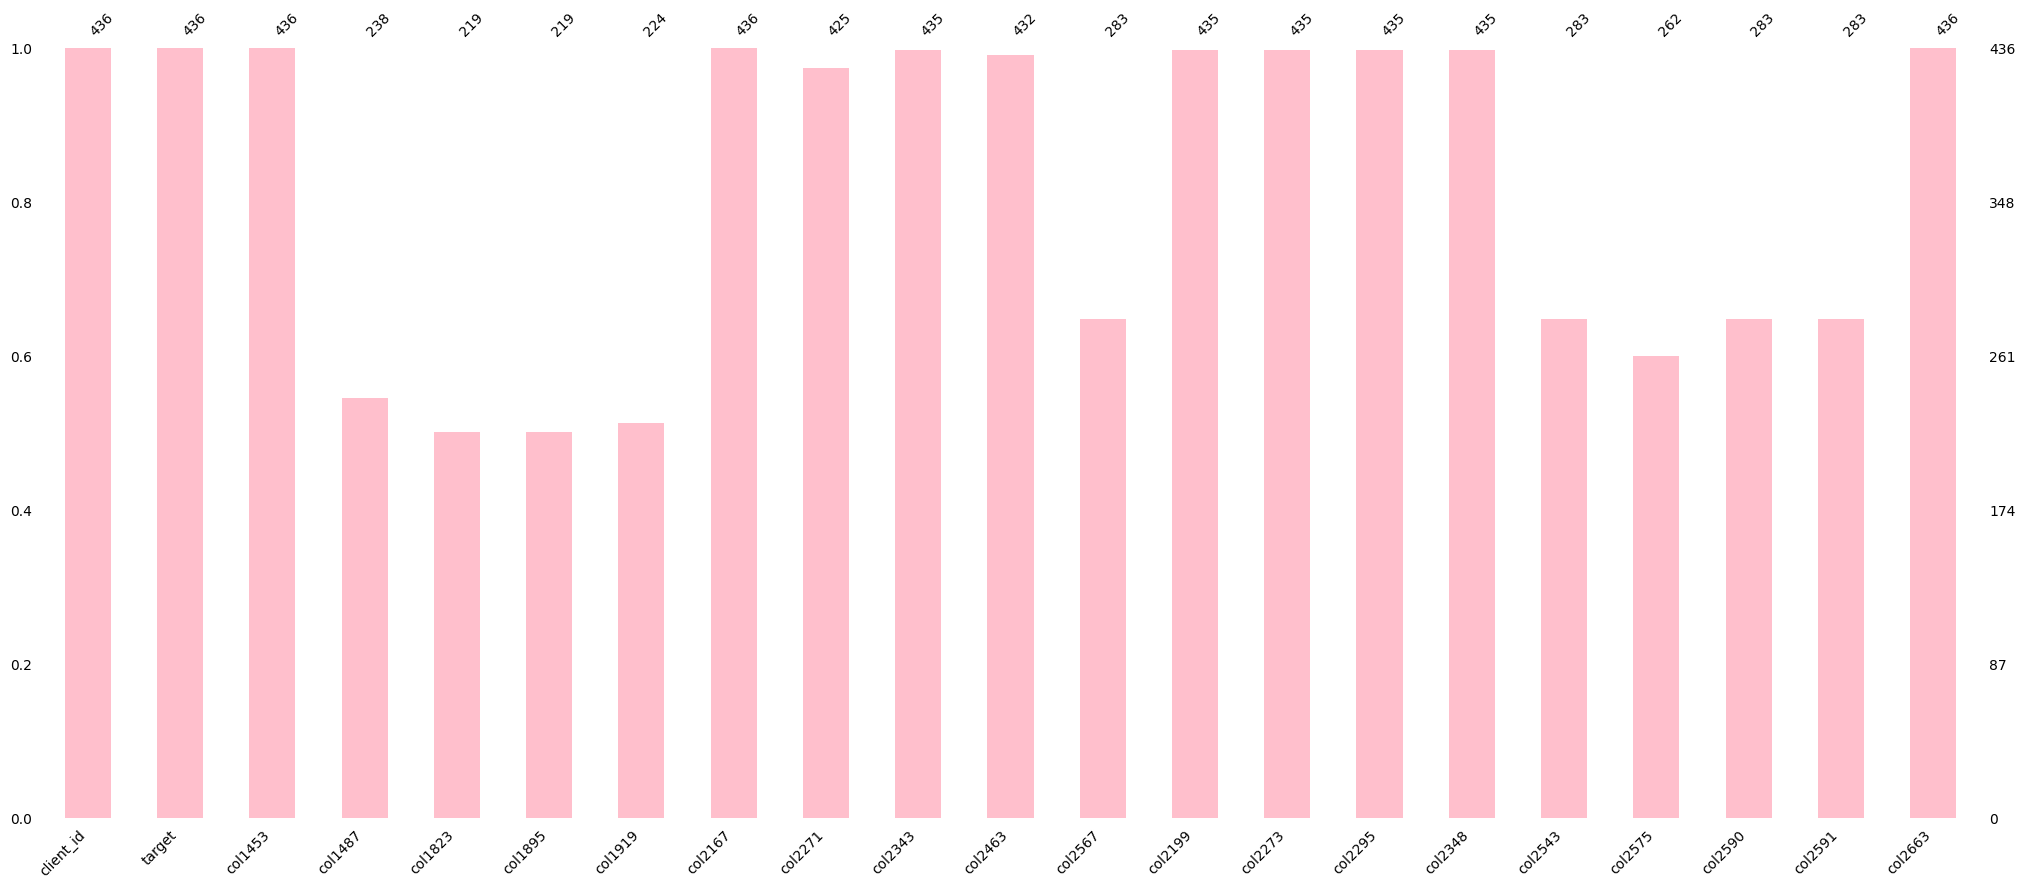

In [11]:
msn.bar(df_target_1, fontsize=10, color=(1, 0.75, 0.8))

При помощи улучшенного алгоритма kNN (аналог KNNImputer из sklearn.impute)

In [12]:
from fancyimpute import KNN

df_filled_0 = pd.DataFrame(KNN(k=12).fit_transform(df_target_0), columns=df_target_0.columns)
df_filled_1 = pd.DataFrame(KNN(k=12).fit_transform(df_target_1), columns=df_target_1.columns)
df_combined = pd.concat([df_filled_0, df_filled_1])

Imputing row 1/14020 with 8 missing, elapsed time: 23.384
Imputing row 101/14020 with 3 missing, elapsed time: 23.412
Imputing row 201/14020 with 8 missing, elapsed time: 23.437
Imputing row 301/14020 with 5 missing, elapsed time: 23.462
Imputing row 401/14020 with 4 missing, elapsed time: 23.487
Imputing row 501/14020 with 4 missing, elapsed time: 23.509
Imputing row 601/14020 with 9 missing, elapsed time: 23.534
Imputing row 701/14020 with 9 missing, elapsed time: 23.563
Imputing row 801/14020 with 4 missing, elapsed time: 23.587
Imputing row 901/14020 with 3 missing, elapsed time: 23.618
Imputing row 1001/14020 with 3 missing, elapsed time: 23.649
Imputing row 1101/14020 with 0 missing, elapsed time: 23.673
Imputing row 1201/14020 with 5 missing, elapsed time: 23.694
Imputing row 1301/14020 with 8 missing, elapsed time: 23.718
Imputing row 1401/14020 with 5 missing, elapsed time: 23.742
Imputing row 1501/14020 with 8 missing, elapsed time: 23.769
Imputing row 1601/14020 with 4 missi

Обучаем модуль и смотрим метрику по ней

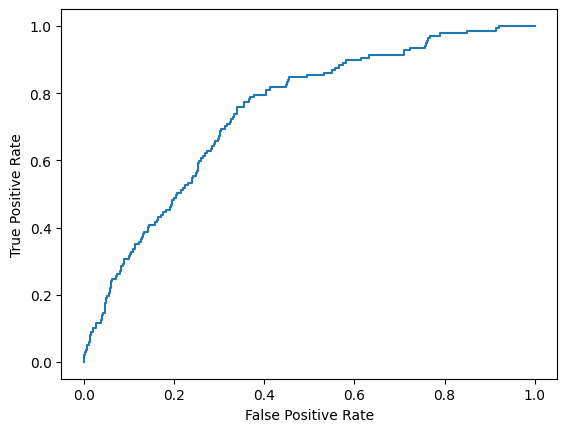

AUC: 0.744


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

data = df_combined
X = data.drop(columns='target')
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# инициализация и обучение модели
log_regression = LogisticRegression()
log_regression.fit(X_train, y_train)

# предсказание вероятностей
y_pred_proba = log_regression.predict_proba(X_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

# построение ROC кривой
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC: %.3f" % auc)